# Real data example

44-year hindcast at 3-hourly resolution from Oceanum's global model

## Warning: these data are not available in the repository

In [1]:
from pathlib import Path
import datetime
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from dask.diagnostics.progress import ProgressBar

from wavespectra import read_wavespectra

datadir = Path("~/Downloads")

In [2]:
dset = xr.open_dataset(datadir / "spectra-global.nc", chunks={}).rename({"point": "site"})
dset = dset.isel(site=0, drop=True)
dset

<xarray.Dataset>
Dimensions:  (dir: 24, time: 126121, freq: 31)
Coordinates:
  * dir      (dir) float32 270.0 255.0 240.0 225.0 ... 330.0 315.0 300.0 285.0
  * freq     (freq) float32 0.037 0.0407 0.04477 ... 0.5336 0.5869 0.6456
  * time     (time) datetime64[ns] 1979-02-01 1979-02-01T03:00:00 ... 2022-04-01
Data variables:
    dpt      (time) float32 dask.array<chunksize=(126121,), meta=np.ndarray>
    efth     (time, freq, dir) float32 dask.array<chunksize=(126121, 31, 24), meta=np.ndarray>
    wdir     (time) float32 dask.array<chunksize=(126121,), meta=np.ndarray>
    wspd     (time) float32 dask.array<chunksize=(126121,), meta=np.ndarray>
Attributes: (12/17)
    altitude_resolution:    n/a
    area:                   Global 0.5 x 0.5 degree
    data_type:              OCO spectra 2D
    easternmost_longitude:  n/a
    field_type:             3-hourly
    format_version:         1.1
    ...                     ...
    product_name:           ww3.all_spec.nc
    southernmost_latitude:  n/a
    start_date:             2022-03-01 00:00:00
    stop_date:              2022-04-01 00:00:00
    westernmost_longitude:  n/a
    xinterp_method:         nearest

### Calculate spectral stats

Havin been built on top of xarray, wavespectra naturally supports out-of-core, parallel computation using dask which makes dealing with very large datasets not only possible but also very efficient.

In [3]:
with ProgressBar():
    ds = dset.spec.stats(["hs", "tp", "dpm"]).load()
ds

[########################################] | 100% Completed |  4.5s


<xarray.Dataset>
Dimensions:  (time: 126121)
Coordinates:
  * time     (time) datetime64[ns] 1979-02-01 1979-02-01T03:00:00 ... 2022-04-01
Data variables:
    hs       (time) float64 2.724 2.766 3.144 3.318 ... 1.667 1.595 1.56 1.531
    tp       (time) float32 7.632 7.706 7.741 8.163 ... 9.2 9.252 9.244 9.212
    dpm      (time) float32 242.0 244.7 255.7 272.0 ... 1.753 2.275 2.358 2.25
Attributes:
    standard_name:  sea_surface_wave_significant_height
    units:          m

### Monthly means

In [4]:
ds_monthly = ds.resample({"time": "MS"}).mean()
ds_monthly

<xarray.Dataset>
Dimensions:  (time: 519)
Coordinates:
  * time     (time) datetime64[ns] 1979-02-01 1979-03-01 ... 2022-04-01
Data variables:
    hs       (time) float64 2.596 2.716 1.73 1.825 ... 3.175 3.383 1.743 1.531
    tp       (time) float32 8.538 8.021 7.136 8.079 ... 9.777 8.923 9.403 9.212
    dpm      (time) float32 221.2 223.9 191.6 242.8 ... 275.9 267.9 241.7 2.25

### Timeseries the full period

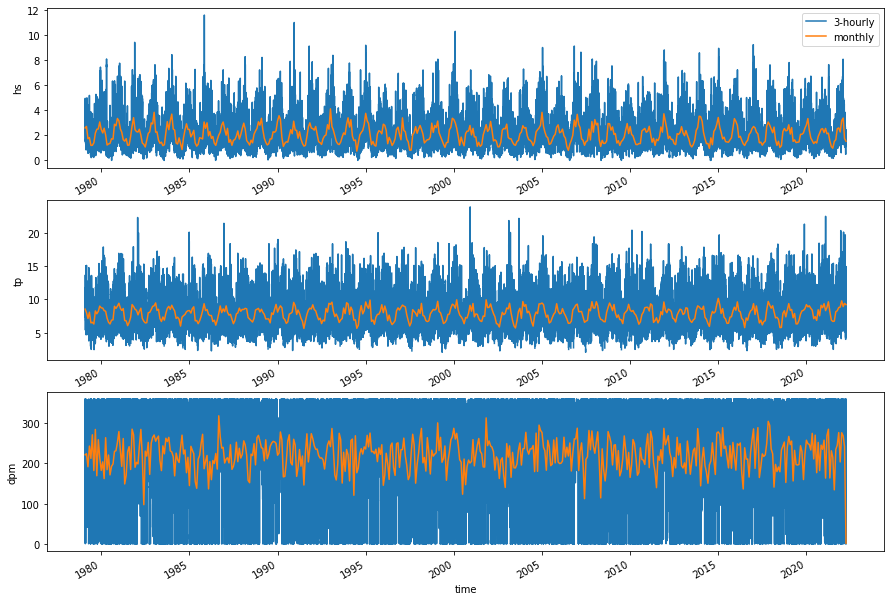

In [5]:
fig = plt.figure(figsize=(15, 10))

ax = fig.add_subplot(311)
ds.hs.plot(label="3-hourly");
ds_monthly.hs.plot(label="monthly");
plt.legend();

ax = fig.add_subplot(312)
ds.tp.plot(label="3-hourly");
ds_monthly.tp.plot(label="monthly");

ax = fig.add_subplot(313)
ds.dpm.plot(label="3-hourly");
ds_monthly.dpm.plot(label="monthly");

### Scatter diagram

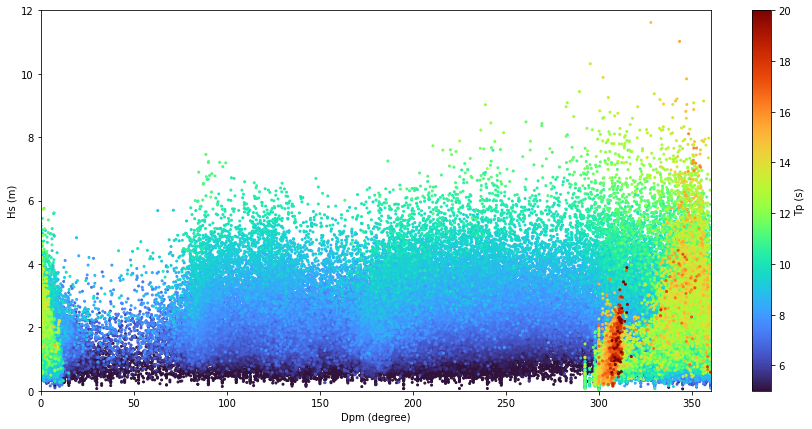

In [6]:
ds_sort = ds.sortby("tp")
fig = plt.figure(figsize=(15, 7))

ax = fig.add_subplot(111)
p = ax.scatter(ds_sort.dpm, ds_sort.hs, s=4, c=ds_sort.tp, vmin=5, vmax=20, cmap="turbo");
plt.colorbar(p, label="Tp (s)");
ax.set_xlim([0, 360])
ax.set_xlabel("Dpm (degree)")
ax.set_ylim([0, 12])
ax.set_ylabel("Hs (m)");

### Plotting the latest month

In [7]:
times = dset.time.to_index()
t1 = times[-1]
t0 = (t1 - datetime.timedelta(days=1)).replace(day=1, hour=0, minute=0)
print(t0)
print(t1)

2022-03-01 00:00:00
2022-04-01 00:00:00


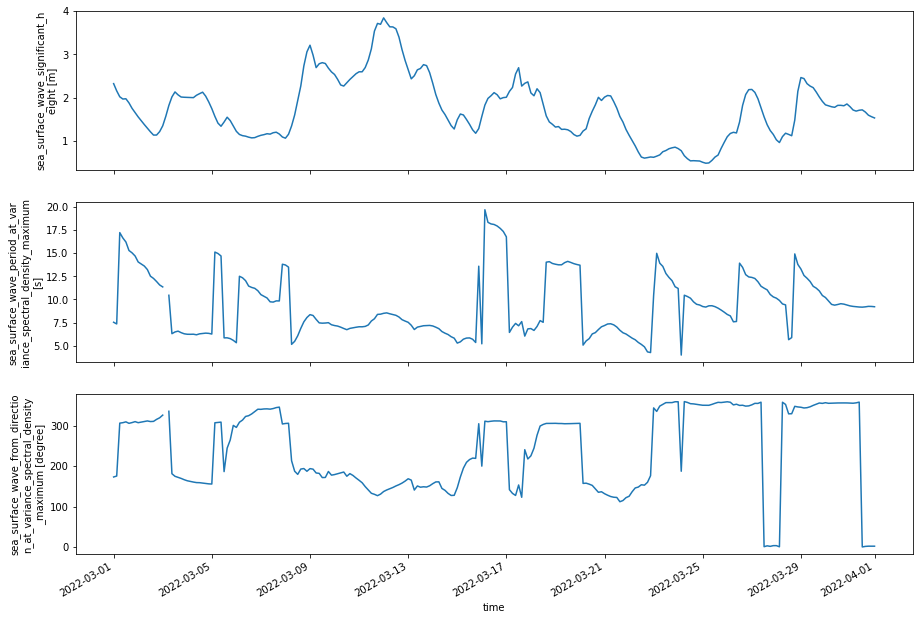

In [8]:
dsmonth = ds.sel(time=slice(t0, t1))

fig = plt.figure(figsize=(15, 10))

ax = fig.add_subplot(311)
dsmonth.hs.plot();
ax.set_xticklabels("")
ax.set_xlabel("")

ax = fig.add_subplot(312)
dsmonth.tp.plot();
ax.set_xticklabels("")
ax.set_xlabel("")

ax = fig.add_subplot(313)
dsmonth.dpm.plot();


### Monthly stats

In [9]:
ds_per_month = ds.groupby("time.month").mean()
ds_per_month

<xarray.Dataset>
Dimensions:  (month: 12)
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    hs       (month) float64 2.874 2.627 2.365 1.822 ... 1.895 2.366 2.598 2.704
    tp       (month) float32 8.796 8.651 8.52 8.069 ... 7.635 8.193 8.529 8.801
    dpm      (month) float32 231.1 227.8 234.0 229.9 ... 230.5 223.2 231.9 235.6

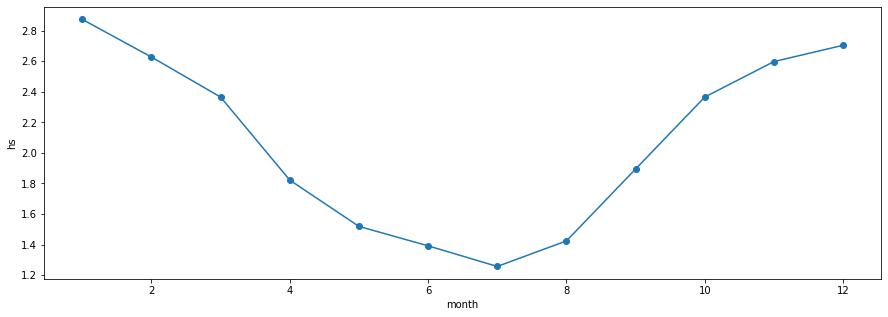

In [10]:
ds_per_month.hs.plot(figsize=(15, 5), marker="o");

### Seasonal stats

In [11]:
ds_per_season = ds.groupby("time.season").mean()
ds_per_season

<xarray.Dataset>
Dimensions:  (season: 4)
Coordinates:
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    hs       (season) float64 2.738 1.357 1.906 2.287
    tp       (season) float32 8.752 6.653 7.984 8.121
    dpm      (season) float32 231.6 205.7 221.9 228.5

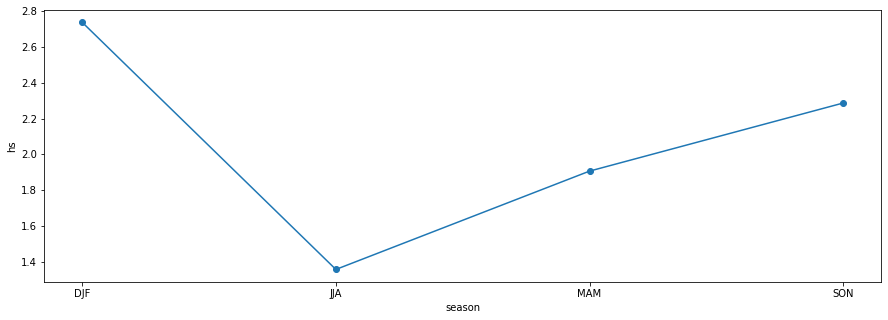

In [12]:
ds_per_season["season"] = ds_per_season.season.astype("U")
ds_per_season.hs.plot(figsize=(15, 5), marker="o");

### Daily-averaged spectra from the last month

In [13]:
dset_daily = dset.sel(time=slice(t0, t1)).resample({"time": "D"}).mean()
dset_daily

<xarray.Dataset>
Dimensions:  (dir: 24, time: 32, freq: 31)
Coordinates:
  * dir      (dir) float32 270.0 255.0 240.0 225.0 ... 330.0 315.0 300.0 285.0
  * freq     (freq) float32 0.037 0.0407 0.04477 ... 0.5336 0.5869 0.6456
  * time     (time) datetime64[ns] 2022-03-01 2022-03-02 ... 2022-04-01
Data variables:
    dpt      (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    efth     (time, freq, dir) float32 dask.array<chunksize=(1, 31, 24), meta=np.ndarray>
    wdir     (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    wspd     (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>

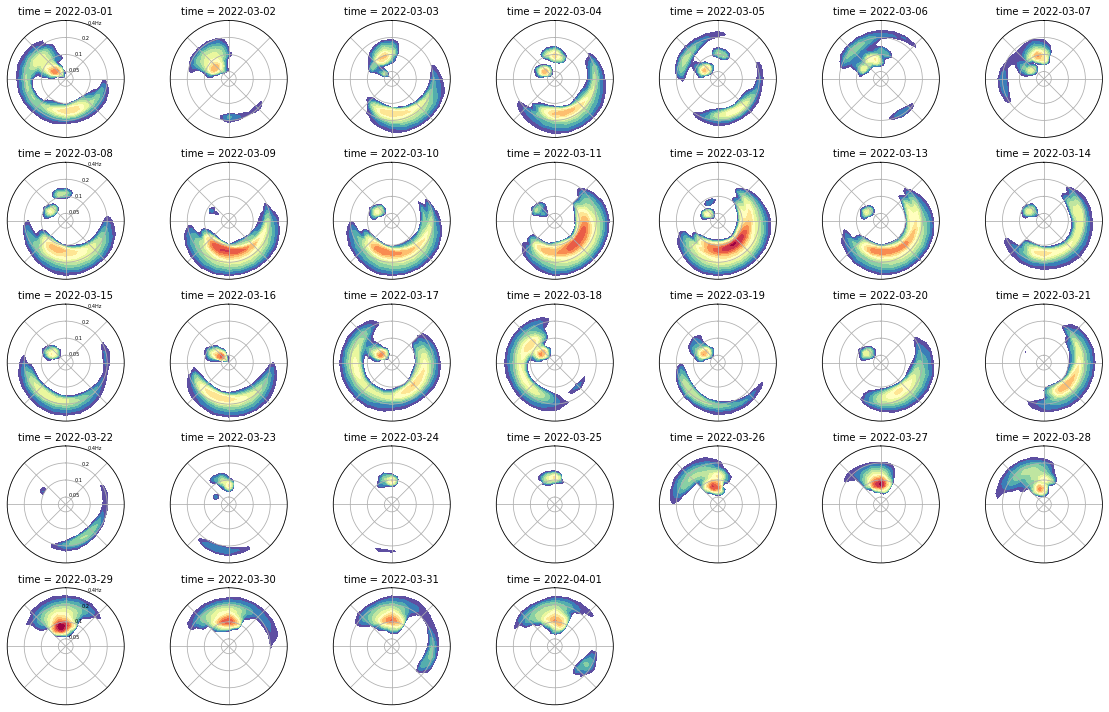

In [14]:
dset_daily.spec.plot(
    col="time",
    col_wrap=7,
    figsize=(16,10),
    add_colorbar=False,
    show_theta_labels=False,
    show_radii_labels=True,
    radii_ticks=[0.05, 0.1, 0.2, 0.4],
    rmax=0.4,
    radii_labels_size=5,
    cmap="Spectral_r",
);
plt.tight_layout();

### Partitions timeseries

In [15]:
fcut = 1 / 8
tp_sea = dset.spec.split(fmin=fcut).spec.tp()
tp_swell = dset.spec.split(fmax=fcut).spec.tp()

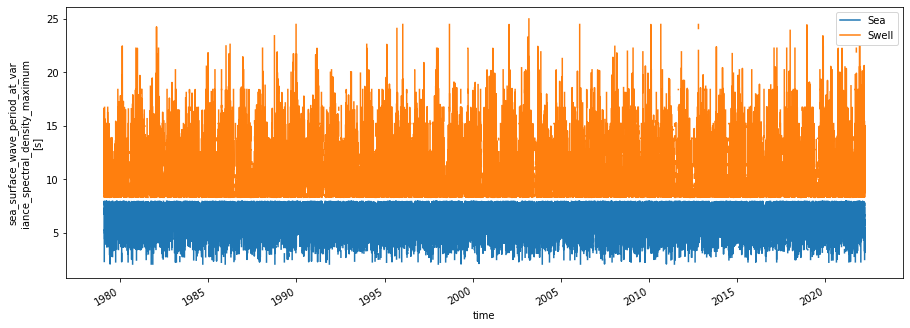

In [16]:
fig = plt.figure(figsize=(15, 5))
tp_sea.plot(label="Sea")
tp_swell.plot(label="Swell")
plt.legend();